# Introduction
Over the course of this notebook I will walk you through my exploration of the RIIID knowledge tracing problem, the dataset, and various solutions in increasing complexity, leading up to my final submission, score, and some conclusions / future directions.

### What is the problem we are solving?


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import gc

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/riiid-test-answer-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py


### Read the main data file using Pickle.  
This is a very large dataset and this can save 20 minutes everytime loading the data like this.

In [5]:
%%time

train = pd.read_pickle("../input/riiid-train-data-multiple-formats/riiid_train.pkl.gzip")

print("Train size:", train.shape)

Train size: (101230332, 10)
CPU times: user 3.63 s, sys: 11.7 s, total: 15.3 s
Wall time: 42.7 s


In [6]:
#Change prior_question_had_explanation Dtype to boolean
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('boolean')

### Read smaller files of dataset using CSV

In [7]:
%%time

questions = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')
lectures = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')
example_test = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_test.csv')
example_sample_submission = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv')

CPU times: user 20.7 ms, sys: 3.15 ms, total: 23.9 ms
Wall time: 58.7 ms


# Exploratory Data Analysis: 
First it is key to understand the data, what does it look like, what are the inputs, what are we trying to predict, is anything missing?

First lets check out a description of the data files from the RIIID competion website:

### train.csv

row_id: (int64) ID code for the row.

timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.

user_id: (int32) ID code for the user.

content_id: (int16) ID code for the user interaction

content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.

user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.

prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.

prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

In [6]:
train.sample(100)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
81144382,81144382,1137302363,1727047028,3414,False,1909,2,1,333.0,True
26671120,26671120,7824976797,569007875,2012,False,1437,3,1,16333.0,True
1250368,1250368,290911,25932669,6472,False,8,0,1,39000.0,False
18881662,18881662,19592625546,405796255,2498,False,124,0,0,30333.0,True
13421348,13421348,1782913165,290415234,6800,False,380,3,0,31000.0,True
...,...,...,...,...,...,...,...,...,...,...
72497990,72497990,1097411774,1542805298,646,False,139,3,1,16000.0,True
44431020,44431020,82501237,940889665,604,False,39,1,0,20000.0,True
66680073,66680073,32491713213,1416597942,11167,False,4960,1,1,31750.0,True
40975966,40975966,51375993601,870517857,4321,False,725,3,0,21000.0,True


In [7]:
train["user_id"].nunique()

393656

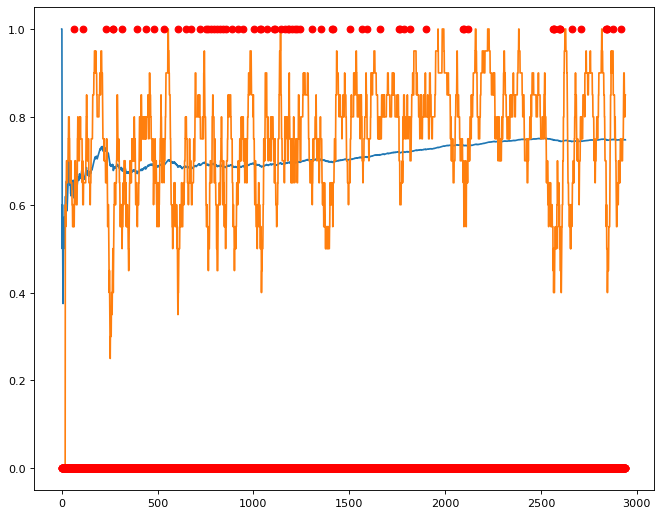

In [8]:
import matplotlib.pyplot as plt
total = 0
count = 0
counts = []
past_10 = []
alls = []
vals = []
a = 25932669
for i in zip(train[train['user_id']==1146441767]["answered_correctly"], train[train['user_id']==1146441767]["content_type_id"]):
    total += 1
    count += i[0]
    counts.append(i[0])
    vals.append(count/total)
    if len(counts) < 20:
        past_10.append(0)
    else:
        past_10.append(sum(counts[-20:])/20)
    if i[1] == False:
        alls.append(0)
    else:
        alls.append(1)
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(vals)
plt.plot(past_10)
plt.plot(alls, 'ro')

When content_type_id is False, a question was asked, when True, a lecture was watched

In [13]:
train.content_type_id.value_counts()

False    99271300
True      1959032
Name: content_type_id, dtype: int64

In [14]:
train.user_answer.value_counts()

 0    28186489
 1    26990007
 3    26084784
 2    18010020
-1     1959032
Name: user_answer, dtype: int64

In [15]:
train.content_id.value_counts()[:30]

6116     213605
6173     202106
4120     199372
175      195861
7876     190170
7900     180858
2065     176043
2064     176043
2063     176043
4492     173769
3365     172575
3364     172574
3363     172573
4696     172408
1278     171098
6370     169945
2946     167589
2947     167589
2948     167588
2595     160858
2594     160858
2593     160857
7218     160300
7217     160300
7216     160300
7219     160298
10686    137001
10688    133046
294      130917
10685    127229
Name: content_id, dtype: int64

In [16]:
train.content_id.nunique()

13782

In [17]:
train.task_container_id.nunique()

10000

In [18]:
train[train.content_id == 5926]
#this shows us a specific question can be in multiple different containers

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
95325,95325,1480489654,2041025,5926,False,852,1,1,25000.0,True
101966,101966,3925576231,2121898,5926,False,536,1,1,70000.0,True
114180,114180,4216303878,2433088,5926,False,1795,1,1,9000.0,True
121060,121060,56146,2491722,5926,False,1,3,0,42000.0,False
224812,224812,16697098853,4357812,5926,False,2579,1,1,44000.0,True
...,...,...,...,...,...,...,...,...,...,...
101085409,101085409,22468096961,2144948249,5926,False,1112,1,1,11000.0,True
101112957,101112957,35213426,2145343445,5926,False,54,1,1,14000.0,True
101145668,101145668,22911426534,2145991556,5926,False,3349,3,0,30000.0,True
101153169,101153169,1565697877,2146130037,5926,False,2566,3,0,34000.0,True


In [19]:
#Credit https://www.kaggle.com/isaienkov/riiid-answer-correctness-prediction-eda-modeling
import plotly.express as px
ds = train['content_id'].value_counts().reset_index()

ds.columns = [
    'content_id', 
    'count'
]

ds = ds.sort_values('content_id')

fig = px.line(
    ds, 
    x='content_id', 
    y='count', 
    title='content_id action distribution', 
    width=800,
    height=600 
)

fig.show()

In [20]:
train['task_container_id'].value_counts().reset_index()

,index,task_container_id
0,14,804285
1,15,798539
2,4,692079
3,5,690051
4,6,688813
...,...,...
9995,9932,174
9996,9999,174
9997,9937,172
9998,9925,172


In [21]:
#https://www.kaggle.com/isaienkov/riiid-answer-correctness-prediction-eda-modeling
ds = train['task_container_id'].value_counts().reset_index()

ds.columns = [
    'task_container_id', 
    'count'
]

ds = ds.sort_values('task_container_id')

fig = px.line(
    ds, 
    x='task_container_id', 
    y='count', 
    title='task_container_id action distribution', 
    width=800,
    height=600  
)

fig.show()

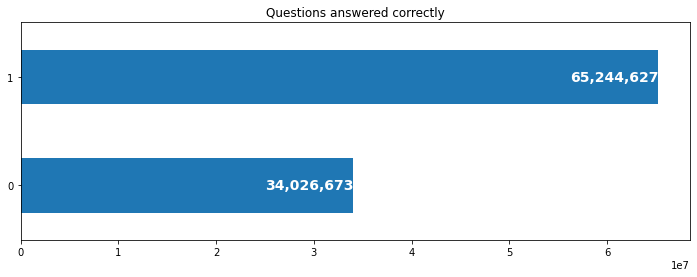

In [22]:
#credit https://www.kaggle.com/erikbruin/riiid-comprehensive-eda-baseline
import matplotlib.pyplot as plt
correct = train[train.answered_correctly != -1].answered_correctly.value_counts(ascending=True)

fig = plt.figure(figsize=(12,4))
correct.plot.barh()
for i, v in zip(correct.index, correct.values):
    plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Questions answered correctly")
plt.xticks(rotation=0)
plt.show()

In [23]:
#https://www.kaggle.com/erikbruin/riiid-comprehensive-eda-baseline
train[train.answered_correctly != -1].groupby(['prior_question_had_explanation'], dropna=False).agg({'answered_correctly': ['mean', 'count']})

answered_correctly          
                                             mean     count
prior_question_had_explanation                             
False                                    0.500629   9193234
True                                     0.673189  89685560
NaN                                      0.680092    392506

### questions.csv: metadata for the questions posed to users.

question_id: foreign key for the train/test content_id column, when the content type is question (0).

bundle_id: code for which questions are served together.

correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.

part: the relevant section of the TOEIC test.

tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

In [24]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


From other EDA notebooks we know there are 188 different tags
We look and add the # correct and incorrect answers per question

In [25]:
#Credit https://www.kaggle.com/erikbruin/riiid-comprehensive-eda-baseline
questions['tags'] = questions['tags'].astype(str)

tags = [x.split() for x in questions[questions.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)
tags_list = [x.split() for x in questions.tags.values]
questions['tags'] = tags_list
questions.head()

correct = train[train.answered_correctly != -1].groupby(["content_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "content_id", columns='answered_correctly', values='size')
correct.columns = ['Wrong', 'Right']
correct = correct.fillna(0)
correct[['Wrong', 'Right']] = correct[['Wrong', 'Right']].astype(int)
questions = questions.merge(correct, left_on = "question_id", right_on = "content_id", how = "left")
questions.head()

,question_id,bundle_id,correct_answer,part,tags,Wrong,Right
0,0,0,0,1,"[51, 131, 162, 38]",637,6266
1,1,1,1,1,"[131, 36, 81]",809,6589
2,2,2,0,1,"[131, 101, 162, 92]",20015,24890
3,3,3,0,1,"[131, 149, 162, 29]",5067,17906
4,4,4,3,1,"[131, 5, 162, 38]",12275,19461


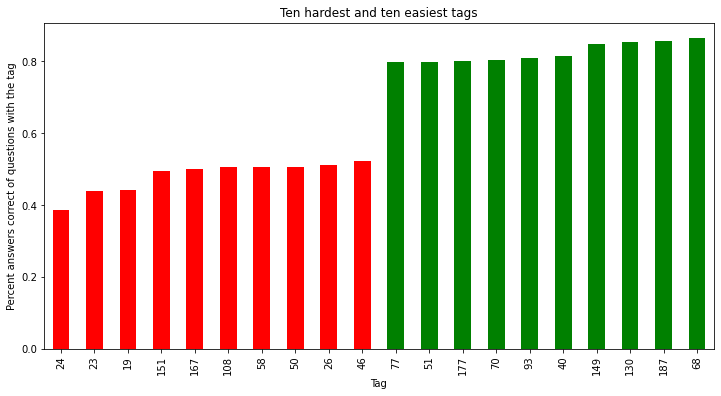

In [26]:
# credit https://www.kaggle.com/erikbruin/riiid-comprehensive-eda-baseline
import matplotlib.pyplot as plt
tags_df = pd.DataFrame()
for x in range(len(tags)):
    df = questions[questions.tags.apply(lambda l: tags[x] in l)]
    df1 = df.agg({'Wrong': ['sum'], 'Right': ['sum']})
    df1['Total_questions'] = df1.Wrong + df1.Right
    df1['Question_ids_with_tag'] = len(df)
    df1['tag'] = tags[x]
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[['Wrong', 'Right', 'Total_questions']] = tags_df[['Wrong', 'Right', 'Total_questions']].astype(int)
tags_df['Percent_correct'] = tags_df.Right/tags_df.Total_questions
tags_df = tags_df.sort_values(by = "Percent_correct")

tags_df.head()
select_rows = list(range(0,10)) + list(range(178, len(tags_df)))
tags_select = tags_df.iloc[select_rows,4]

fig = plt.figure(figsize=(12,6))
x = tags_select.index
y = tags_select.values
clrs = ['red' if y < 0.6 else 'green' for y in tags_select.values]
tags_select.plot.bar(x, y, color=clrs)
plt.title("Ten hardest and ten easiest tags")
plt.xlabel("Tag")
plt.ylabel("Percent answers correct of questions with the tag")
plt.xticks(rotation=90)
plt.show()

### lectures.csv: metadata for the lectures watched by users as they progress in their education.

lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).

part: top level category code for the lecture.

tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.

type_of: brief description of the core purpose of the lecture

In [27]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [28]:
lectures.shape

(418, 4)

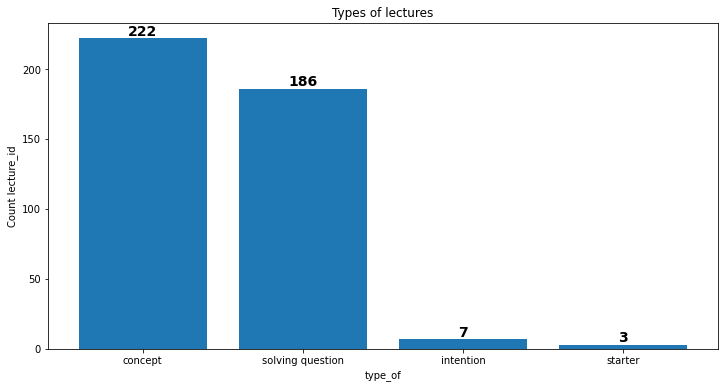

In [29]:
#credit https://www.kaggle.com/erikbruin/riiid-comprehensive-eda-baseline
lect_type_of = lectures.type_of.value_counts()

fig = plt.figure(figsize=(12,6))
plt.bar(lect_type_of.index, lect_type_of.values)
for i, v in zip(lect_type_of.index, lect_type_of.values):
    plt.text(i, v, v, color='black', fontweight='bold', fontsize=14, va='bottom', ha='center')
plt.title("Types of lectures")
plt.xlabel("type_of")
plt.ylabel("Count lecture_id")
plt.xticks(rotation=0)
plt.show()

False    244050
True     149606
Name: Watches_lecture, dtype: int64


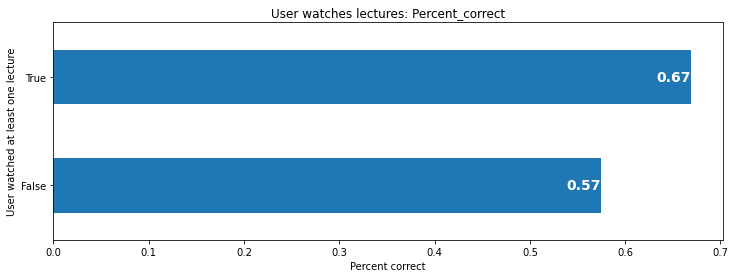

In [30]:
#credit https://www.kaggle.com/erikbruin/riiid-comprehensive-eda-baseline

user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', 'Right']
user_lect['Lecture'] = user_lect['Lecture'].fillna(0)
user_lect = user_lect.astype('Int64')
user_lect['Watches_lecture'] = np.where(user_lect.Lecture > 0, True, False)

watches_l = user_lect.groupby("Watches_lecture").agg({'Wrong': ['sum'], 'Right': ['sum']})
print(user_lect.Watches_lecture.value_counts())

watches_l['Percent_correct'] = watches_l.Right/(watches_l.Right + watches_l.Wrong)

watches_l = watches_l.iloc[:,2]

fig = plt.figure(figsize=(12,4))
watches_l.plot.barh()
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("User watches lectures: Percent_correct")
plt.xlabel("Percent correct")
plt.ylabel("User watched at least one lecture")
plt.xticks(rotation=0)
plt.show()

In [31]:
#credit https://www.kaggle.com/isaienkov/riiid-answer-correctness-prediction-eda-modeling
ds = lectures['tag'].value_counts().reset_index()

ds.columns = [
    'tag', 
    'count'
]

ds['tag'] = ds['tag'].astype(str) + '-'
ds = ds.sort_values(['count']).tail(40)

fig = px.bar(
    ds, 
    x='count', 
    y='tag', 
    orientation='h', 
    title='Top 40 lectures by number of tags', 
    height=900, 
    width=800
)

fig.show()

### example_test_rows.csv 
Three sample groups of the test set data as it will be delivered by the time-series API. The format is largely the same as train.csv. There are two different columns that mirror what information the AI tutor actually has available at any given time, but with the user interactions grouped together for the sake of API performance rather than strictly showing information for a single user at a time. Some users will appear in the hidden test set that have NOT been presented in the train set, emulating the challenge of quickly adapting to modeling new arrivals to a website.

prior_group_responses (string) provides all of the user_answer entries for previous group in a string representation of a list in the first row of the group. All other rows in each group are null. If you are using Python, you will likely want to call eval on the non-null rows. Some rows may be null, or empty lists.

prior_group_answers_correct (string) provides all the answered_correctly field for previous group, with the same format and caveats as prior_group_responses. Some rows may be null, or empty lists.

In [32]:
example_test.head()

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
0,0,0,0,275030867,5729,0,0,NaN,NaN,[],[]
1,1,0,13309898705,554169193,12010,0,4427,19000.0,True,NaN,NaN
2,2,0,4213672059,1720860329,457,0,240,17000.0,True,NaN,NaN
3,3,0,62798072960,288641214,13262,0,266,23000.0,True,NaN,NaN
4,4,0,10585422061,1728340777,6119,0,162,72400.0,True,NaN,NaN


In [33]:
example_sample_submission.head()

,row_id,answered_correctly,group_num
0,0,0.5,0
1,1,0.5,0
2,2,0.5,0
3,3,0.5,0
4,4,0.5,0


# Baseline Model
This model will always return that the student answered the question correctly.

## Baseline model for final submission

In [ ]:
import riiideducation
env = riiideducation.make_env()

In [ ]:
iter_test = env.iter_test()

In [ ]:
for (test_df, sample_prediction_df) in iter_test:
    test_df['answered_correctly'] = 1.0
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])

This got .5 AUC

## Baseline model performance on training data

In [34]:
import sklearn.metrics as metrics

In [35]:
base_train = train[["timestamp", "user_id", "content_id", "answered_correctly"]]
base_train.head()

,timestamp,user_id,content_id,answered_correctly
0,0,115,5692,1
1,56943,115,5716,1
2,118363,115,128,1
3,131167,115,7860,1
4,137965,115,7922,1


In [36]:
answer_guesses = np.ones((base_train.shape[0]))
answer_actual = base_train["answered_correctly"]
fpr, tpr, thresholds = metrics.roc_curve(answer_actual, answer_guesses, pos_label=1)
baseline_AUC = metrics.auc(fpr, tpr)
baseline_accuracy = base_train["answered_correctly"].sum()/base_train.shape[0]
print("baseline training accuracy", baseline_accuracy)
print("baseline training AUC", baseline_AUC)

baseline training accuracy 0.6251643529135121
baseline training AUC 0.5


# Logistic Regression Model
Credit to https://www.kaggle.com/lgreig/simple-logistic-baseline

Sort the data by timestamp

In [ ]:
logtrain = train[["timestamp", "user_id", "content_id", "answered_correctly"]]
logtrain.head()

In [ ]:
logtrain = logtrain.sort_values(['timestamp'], ascending=True)

In [ ]:
logtrain.drop(['timestamp'], axis=1, inplace=True)

In [ ]:
logtrain.head()

Create values for user mean answer score and mean answer scores based on content type from first 90,000,000 datapoints

In [ ]:
user_results = logtrain.iloc[0:90000000, :][["user_id", "answered_correctly"]].groupby(["user_id"]).agg(["mean"])
content_results = logtrain.iloc[0:90000000, :][["content_id", "answered_correctly"]].groupby(["content_id"]).agg(["mean"])

Combine this to our training data for this model, the next 90000000 rows, and fill NA with .5

In [ ]:
content_results.columns = ["content_results"]
user_results.columns = ["user_results"]
X = logtrain.iloc[90000000:99000000,:]
X = pd.merge(X, user_results, on=['user_id'], how="left")
X = pd.merge(X, content_results, on=['content_id'], how="left")
X.fillna(0.5,  inplace=True)

In [ ]:
X=X[X.answered_correctly!= -1 ]
X=X.sort_values(['user_id'])
Y = X[["answered_correctly"]]
X = X.drop(["answered_correctly"], axis=1)
X.head()

In [ ]:
Y

The features for the logistic regression model will be the user_results and content_results, and it is attempting to predict the target "answered_correctly"

In [ ]:
X = X[["user_results", "content_results"]]

In [ ]:
Use logistic regression model from Sklearn

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
LogReg = LogisticRegression(penalty='l2')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size =0.25, shuffle=False)
LogReg.fit(X_train, np.array(y_train))

> print("Accuracy on validation data: ", LogReg.score(X_test, y_test))

In [ ]:
print("Accuracy on validation data: ", LogReg.score(X_test, y_test))
pred = LogReg.predict_proba(X_test)[:,1]
pred.shape
import sklearn.metrics as metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)
baseline_AUC = metrics.auc(fpr, tpr)
print("baseline validation AUC", baseline_AUC)

In [ ]:
user_results = logtrain[["user_id", "answered_correctly"]].groupby(["user_id"]).agg(["mean"])
content_results = logtrain[["content_id", "answered_correctly"]].groupby(["content_id"]).agg(["mean"])
content_results.columns = ["content_results"]
user_results.columns = ["user_results"]

Submission

In [ ]:
import riiideducation env = riiideducation.make_env() iter_test = env.iter_test()

In [ ]:
for (test_df, sample_prediction_df) in iter_test:
    new_test = test_df[["user_id", "content_id"]]
    new_test = pd.merge(new_test, user_results, on=['user_id'], how="left")
    new_test = pd.merge(new_test, content_results, on=['content_id'], how="left")
    new_test = new_test[["user_results", "content_results"]]
    new_test.fillna(0.5,  inplace=True)
    test_df["answered_correctly"] = LogReg.predict_proba(new_test)[:,1]
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])

# CNN, LSTM

In [ ]:
import riiideducation
env = riiideducation.make_env()
iter_test = env.iter_test()

In [6]:
train = train.sort_values(['timestamp'], ascending=True).reset_index(drop = True)

In [7]:
import gc
gc.collect()

56

In [8]:
train = train.fillna({"prior_question_had_explanation": False})
train["prior_question_had_explanation"] = train["prior_question_had_explanation"].astype('int')
user_results = train[["user_id", "answered_correctly"]].groupby(["user_id"]).agg(["mean"]).fillna(0.5)
user_results.columns = ["user_results"]
gc.collect()
content_results = train[["content_id", "answered_correctly"]].groupby(["content_id"]).agg(["mean"]).fillna(0.5)
content_results.columns = ["content_results"]
task_results = train[["task_container_id", "answered_correctly"]].groupby(["task_container_id"]).agg(["mean"]).fillna(0.5)
task_results.columns = ["task_results"]
num_content_questions = train[["content_id"]].value_counts().fillna(0)
gc.collect()
num_task_questions = train[["task_container_id"]].value_counts().fillna(0)
num_user_questions = train[["user_id"]].value_counts().fillna(0)
train = train.iloc[-20000:, :]
gc.collect()

0

In [9]:
import tensorflow as tf

In [10]:
new_test = train[["user_id", "content_id", "timestamp", "task_container_id", "answered_correctly"]]
new_test = pd.merge(new_test, user_results, on=['user_id'], how="left")
new_test = pd.merge(new_test, content_results, on=['content_id'], how="left")
new_test = pd.merge(new_test, num_user_questions.rename('user_question_count'), on=['user_id'], how="left")
new_test = pd.merge(new_test,  num_content_questions.rename('content_question_count'), on=['content_id'], how="left")
new_test = pd.merge(new_test,  num_task_questions.rename('num_task_questions'), on=['task_container_id'], how="left")
new_test = pd.merge(new_test, task_results, on=['task_container_id'], how="left")
new_test.fillna({"user_results": .5, "content_results": .5, "task_results": .5, "user_question_count": 0, "content_question_count": 0, "num_task_questions": 0})

,user_id,content_id,timestamp,task_container_id,answered_correctly,user_results,content_results,user_question_count,content_question_count,num_task_questions,task_results
0,1216339429,10186,78126318791,2368,0,0.592549,0.763153,4268,4999,6373,0.669386
1,662166016,8648,78126386881,1907,0,0.492916,0.548015,2047,10653,9208,0.662576
2,662166016,5691,78126406429,1908,0,0.492916,0.456113,2047,23082,9258,0.666667
3,662166016,5449,78126421766,1909,1,0.492916,0.820897,2047,8805,9132,0.661520
4,662166016,3762,78126446473,1910,1,0.492916,0.589407,2047,13500,9141,0.672574
...,...,...,...,...,...,...,...,...,...,...,...
19995,626308830,8185,87193076570,9217,0,0.682344,0.474599,12545,6850,214,0.705607
19996,626308830,6686,87193279051,9218,0,0.682344,0.432758,12545,12284,219,0.757991
19997,626308830,5860,87193332075,9219,1,0.682344,0.489271,12545,5639,219,0.730594
19998,626308830,11465,87193355096,9220,0,0.682344,0.519852,12545,2166,218,0.692661


In [11]:
X = new_test[["answered_correctly", "user_results", "content_results", "user_question_count", "content_question_count", "num_task_questions", "task_results"]]
y = X.pop("answered_correctly")
mean = X.mean()
std = X.std()
X=(X-mean)/std
print(mean, std)
print(X.head())
X = pd.concat([X, y], axis=1, sort=False)

user_results                  0.641224
content_results               0.606211
user_question_count        3247.412150
content_question_count    12028.035200
num_task_questions        26535.335900
task_results                  0.663128
dtype: float64 user_results                  0.082523
content_results               0.293980
user_question_count        2467.576338
content_question_count    18455.270278
num_task_questions        35744.303251
task_results                  0.029864
dtype: float64
   user_results  content_results  user_question_count  content_question_count  \
0     -0.589839         0.533852             0.413599               -0.380869   
1     -1.797175        -0.197959            -0.486474               -0.074506   
2     -1.797175        -0.510571            -0.486474                0.598960   
3     -1.797175         0.730275            -0.486474               -0.174640   
4     -1.797175        -0.057158            -0.486474                0.079759   

   num_task_que

In [12]:
#Window generator from https://www.tensorflow.org/tutorials/structured_data/time_series
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=X,
               label_columns=None):
    # Store the raw data.
    self.train_df = X

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [13]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [14]:
w1 = WindowGenerator(input_width=5, label_width=1, shift=1,
                     label_columns=['answered_correctly'])

In [ ]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [15]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(5),
                           activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])
conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

In [16]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0005),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

In [17]:
lstm_model.fit(w1.train, shuffle=False, verbose=1, epochs=10)

Epoch 1/10
625/625 [==============================] - 4s 7ms/step - loss: 0.6507 - accuracy: 0.6433
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.6455 - accuracy: 0.6482
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.6441 - accuracy: 0.6498
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.6432 - accuracy: 0.6508
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.6427 - accuracy: 0.6505
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.6423 - accuracy: 0.6504
Epoch 7/10
625/625 [==============================] - 4s 6ms/step - loss: 0.6420 - accuracy: 0.6508
Epoch 8/10
625/625 [==============================] - 4s 6ms/step - loss: 0.6417 - accuracy: 0.6502
Epoch 9/10
625/625 [==============================] - 4s 6ms/step - loss: 0.6415 - accuracy: 0.6500
Epoch 10/10
625/625 [==============================] - 4s 6ms/step - loss: 0.6412 - accuracy: 0.6507

In [18]:
w1 = WindowGenerator(input_width=5, label_width=1, shift=1,
                     label_columns=['answered_correctly'])
conv_model.fit(w1.train, shuffle=False, verbose=1, epochs=10)

Epoch 1/10
625/625 [==============================] - 3s 5ms/step - loss: 0.6968 - accuracy: 0.5526
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.6607 - accuracy: 0.6247
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.6546 - accuracy: 0.6345
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.6514 - accuracy: 0.6379
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.6493 - accuracy: 0.6420
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.6478 - accuracy: 0.6430
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.6466 - accuracy: 0.6442
Epoch 8/10
625/625 [==============================] - 3s 4ms/step - loss: 0.6457 - accuracy: 0.6442
Epoch 9/10
625/625 [==============================] - 3s 5ms/step - loss: 0.6450 - accuracy: 0.6457
Epoch 10/10
625/625 [==============================] - 3s 5ms/step - loss: 0.6444 - accuracy: 0.6457

# LGBM notebook

# Basic Deep Learning Notebook

# Best Model Notebook